In [73]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr
from sklearn.metrics import mean_absolute_error


In [74]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [75]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
#df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
#df['month'] = df['time'].dt.month

df = df[df['location'] != 'helsingfors']


In [76]:
excluded_features_0_10 = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 'temperature', 'original_location']

In [77]:

lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag) 

    if lag < 48:
        excluded_features_11_24.append(f'load_t-{lag}h')
        excluded_features_11_24.append(f'temperature_t-{lag}h')
    

df.dropna(inplace=True)

In [78]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [79]:
from datetime import timedelta

def split_train_test_by_location(df, hour_limit=10):
    train_dfs = []
    test_dfs = []
    
    last_date = df['time'].max().date()
    test_start_date = last_date - timedelta(days=30)
    
    # Filter data based on hour
    if hour_limit == 10:
        df_filtered = df[df['hour'] <= 10].copy()
    else:
        df_filtered = df[df['hour'] > 10].copy()
    
    for location in df_filtered['original_location'].unique():
        location_data = df_filtered[df_filtered['original_location'] == location]
        
        # Split data based on time logic
        train_df = location_data[location_data['time'].dt.date < test_start_date]
        test_df = location_data[location_data['time'].dt.date >= test_start_date]
        
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    
    # Combine the training data and testing data
    combined_train_df = pd.concat(train_dfs)
    combined_test_df = pd.concat(test_dfs)
    
    return combined_train_df, combined_test_df


In [80]:
last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=30)

train_df = df[df['time'].dt.date < test_start_date]
test_df = df[df['time'].dt.date >= test_start_date]

train_dfs_locations = {}
test_dfs_locations = {}

for loc in train_df['original_location'].unique():
    train_dfs_locations[loc] = train_df[train_df['original_location'] == loc]
    test_dfs_locations[loc] = test_df[test_df['original_location'] == loc]

combined_train_df = pd.concat([train_dfs_locations[loc] for loc in train_df['original_location'].unique()])
combined_test_df = pd.concat([test_dfs_locations[loc] for loc in train_df['original_location'].unique()])


In [81]:
def train_and_test_for_location(train_data, test_data, excluded_features):
    results = {}

    for location in train_data['original_location'].unique():
        location_train = train_data[train_data['original_location'] == location]
        location_test = test_data[test_data['original_location'] == location]
        

        pyr.setup(data=location_train, target='consumption', fold_strategy='timeseries',ignore_features=excluded_features,
                   session_id=42, fold_shuffle=False, data_split_shuffle=False)

        model = pyr.create_model('et')

        model = pyr.tune_model(model)

        model = pyr.finalize_model(model)

        predictions = pyr.predict_model(model, data=location_test)

        results[location] = predictions

    return results


In [82]:
train_0_10, test_0_10 = split_train_test_by_location(df, hour_limit=10)
train_11_24, test_11_24 = split_train_test_by_location(df, hour_limit=11)




In [83]:


results_0_10 = train_and_test_for_location(train_0_10, test_0_10, excluded_features=excluded_features_0_10)
results_11_24 = train_and_test_for_location(train_11_24, test_11_24,excluded_features=excluded_features_11_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3531, 25)"
4,Transformed data shape,"(3531, 22)"
5,Transformed train set shape,"(2471, 22)"
6,Transformed test set shape,"(1060, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:18:31
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0680,0.0080,0.0897,0.1596,0.0528,0.1020
1,0.0734,0.0088,0.0936,0.1898,0.0542,0.0982
2,0.0726,0.0079,0.0890,0.3030,0.0539,0.1165
3,0.0885,0.0112,0.1057,0.0666,0.0612,0.1151
4,0.1022,0.0143,0.1198,-0.1678,0.0669,0.1229
5,0.0829,0.0105,0.1026,0.1366,0.0571,0.0999
6,0.1521,0.0327,0.1807,-0.6890,0.0964,0.1592
7,0.3860,0.2057,0.4536,-2.0730,0.2035,0.2676
8,0.1650,0.0395,0.1987,0.0107,0.0739,0.0991


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:18:37
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0717,0.0087,0.0931,0.0940,0.0551,0.1090
1,0.0758,0.0091,0.0954,0.1586,0.0547,0.1032
2,0.0761,0.0096,0.0979,0.1569,0.0593,0.1252
3,0.0853,0.0113,0.1064,0.0542,0.0597,0.1073
4,0.0930,0.0135,0.1161,-0.0974,0.0632,0.1092
5,0.0709,0.0091,0.0953,0.2545,0.0515,0.0821
6,0.1491,0.0326,0.1804,-0.6836,0.0951,0.1540
7,0.4044,0.2128,0.4613,-2.1780,0.2079,0.2841
8,0.1723,0.0471,0.2170,-0.1796,0.0799,0.0994


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0717,0.0087,0.0931,0.0940,0.0551,0.1090
1,0.0758,0.0091,0.0954,0.1586,0.0547,0.1032
2,0.0761,0.0096,0.0979,0.1569,0.0593,0.1252
3,0.0853,0.0113,0.1064,0.0542,0.0597,0.1073
4,0.0930,0.0135,0.1161,-0.0974,0.0632,0.1092
5,0.0709,0.0091,0.0953,0.2545,0.0515,0.0821
6,0.1491,0.0326,0.1804,-0.6836,0.0951,0.1540
7,0.4044,0.2128,0.4613,-2.1780,0.2079,0.2841
8,0.1723,0.0471,0.2170,-0.1796,0.0799,0.0994


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2854,0.1160,0.3406,0.3803,0.0861,0.1010


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3531, 25)"
4,Transformed data shape,"(3531, 22)"
5,Transformed train set shape,"(2471, 22)"
6,Transformed test set shape,"(1060, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:18:49
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3600,0.1679,0.4098,-0.9725,0.1282,0.1799
1,0.1494,0.0366,0.1912,0.5649,0.0581,0.0652
2,0.1407,0.0339,0.1841,0.5630,0.0611,0.0729
3,0.0975,0.0142,0.1193,0.8068,0.0392,0.0481
4,0.2118,0.0597,0.2443,0.3938,0.0744,0.0897
5,0.3036,0.1526,0.3907,0.0414,0.1084,0.1107
6,0.5456,0.4409,0.6640,-1.2257,0.1667,0.1646
7,1.0984,1.6240,1.2744,-1.7598,0.2354,0.2197
8,0.6398,0.6211,0.7881,-0.1905,0.1089,0.1018


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:18:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3624,0.1699,0.4122,-0.9961,0.1294,0.1817
1,0.1760,0.0496,0.2227,0.4099,0.0676,0.0782
2,0.1753,0.0494,0.2222,0.3635,0.0740,0.0917
3,0.1125,0.0189,0.1376,0.7432,0.0454,0.0566
4,0.1917,0.0574,0.2395,0.4176,0.0700,0.0787
5,0.3066,0.1719,0.4146,-0.0799,0.1115,0.1084
6,0.6040,0.4938,0.7027,-1.4929,0.1743,0.1822
7,1.3095,2.1325,1.4603,-2.6239,0.2758,0.2647
8,0.7181,0.8980,0.9476,-0.7212,0.1300,0.1081


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3624,0.1699,0.4122,-0.9961,0.1294,0.1817
1,0.1760,0.0496,0.2227,0.4099,0.0676,0.0782
2,0.1753,0.0494,0.2222,0.3635,0.0740,0.0917
3,0.1125,0.0189,0.1376,0.7432,0.0454,0.0566
4,0.1917,0.0574,0.2395,0.4176,0.0700,0.0787
5,0.3066,0.1719,0.4146,-0.0799,0.1115,0.1084
6,0.6040,0.4938,0.7027,-1.4929,0.1743,0.1822
7,1.3095,2.1325,1.4603,-2.6239,0.2758,0.2647
8,0.7181,0.8980,0.9476,-0.7212,0.1300,0.1081


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.0843,1.7081,1.3069,0.1774,0.1055,0.1005


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:19:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1471,0.0300,0.1733,-0.6764,0.0810,0.1390
1,0.1118,0.0230,0.1516,0.0213,0.0660,0.0844
2,0.0921,0.0156,0.1250,0.4349,0.0573,0.0829
3,0.0848,0.0115,0.1073,0.6279,0.0489,0.0744
4,0.0860,0.0142,0.1192,0.5603,0.0507,0.0667
5,0.1129,0.0232,0.1523,0.3035,0.0632,0.0816
6,0.2232,0.0736,0.2713,-0.5573,0.1091,0.1405
7,0.8013,0.7822,0.8844,-3.3693,0.2905,0.3276
8,0.2874,0.1322,0.3637,-0.3039,0.0896,0.0921


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5065,0.3938,0.6275,0.0671,0.0988,0.1008


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3531, 25)"
4,Transformed data shape,"(3531, 22)"
5,Transformed train set shape,"(2471, 22)"
6,Transformed test set shape,"(1060, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:19:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1145,0.0212,0.1457,0.0821,0.0790,0.1456
1,0.0906,0.0125,0.1117,-0.1437,0.0662,0.1420
2,0.1162,0.0189,0.1374,-0.3032,0.0884,0.2395
3,0.0537,0.0046,0.0676,0.2373,0.0422,0.0908
4,0.0768,0.0090,0.0950,-0.0400,0.0564,0.1100
5,0.1218,0.0210,0.1450,-0.1522,0.0819,0.1519
6,0.0946,0.0133,0.1151,-0.9287,0.0613,0.1025
7,0.1898,0.0504,0.2244,-1.2569,0.1092,0.1643
8,0.2460,0.0776,0.2786,-2.7762,0.1198,0.1699


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1178,0.0192,0.1385,0.0255,0.0477,0.0612


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(3531, 25)"
4,Transformed data shape,"(3531, 22)"
5,Transformed train set shape,"(2471, 22)"
6,Transformed test set shape,"(1060, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:19:32
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2071,0.0633,0.2517,-0.3654,0.1146,0.1907
1,0.1028,0.0175,0.1321,0.2824,0.0625,0.0947
2,0.1654,0.0395,0.1987,-1.2171,0.1025,0.1986
3,0.0907,0.0123,0.1107,0.1667,0.0547,0.0856
4,0.0874,0.0121,0.1101,0.2683,0.0532,0.0797
5,0.1367,0.0268,0.1637,-0.2588,0.0773,0.1156
6,0.1847,0.0485,0.2203,-0.6940,0.0963,0.1326
7,0.3914,0.2109,0.4593,-1.2864,0.1751,0.2158
8,0.2109,0.0660,0.2568,-0.2323,0.0840,0.1022


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:19:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2058,0.0607,0.2464,-0.3081,0.1126,0.1907
1,0.1100,0.0205,0.1433,0.1562,0.0685,0.1066
2,0.1489,0.0322,0.1793,-0.8062,0.0937,0.1804
3,0.0963,0.0145,0.1202,0.0178,0.0583,0.0889
4,0.0983,0.0147,0.1212,0.1133,0.0581,0.0895
5,0.1208,0.0236,0.1535,-0.1069,0.0705,0.0991
6,0.1755,0.0476,0.2183,-0.6628,0.0929,0.1223
7,0.3752,0.2061,0.4540,-1.2338,0.1713,0.2026
8,0.2290,0.0836,0.2891,-0.5611,0.0941,0.1061


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2058,0.0607,0.2464,-0.3081,0.1126,0.1907
1,0.1100,0.0205,0.1433,0.1562,0.0685,0.1066
2,0.1489,0.0322,0.1793,-0.8062,0.0937,0.1804
3,0.0963,0.0145,0.1202,0.0178,0.0583,0.0889
4,0.0983,0.0147,0.1212,0.1133,0.0581,0.0895
5,0.1208,0.0236,0.1535,-0.1069,0.0705,0.0991
6,0.1755,0.0476,0.2183,-0.6628,0.0929,0.1223
7,0.3752,0.2061,0.4540,-1.2338,0.1713,0.2026
8,0.2290,0.0836,0.2891,-0.5611,0.0941,0.1061


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2664,0.1113,0.3336,0.3403,0.0724,0.0756


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4176, 25)"
4,Transformed data shape,"(4176, 16)"
5,Transformed train set shape,"(2923, 16)"
6,Transformed test set shape,"(1253, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:19:47
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0683,0.0073,0.0856,0.2143,0.0484,0.0895
1,0.1020,0.0163,0.1276,-0.3541,0.0687,0.1151
2,0.0899,0.0113,0.1064,0.1687,0.0582,0.1093
3,0.1040,0.0162,0.1271,-0.4032,0.0666,0.1096
4,0.1371,0.0271,0.1646,-0.9490,0.0835,0.1319
5,0.1042,0.0162,0.1272,0.0071,0.0638,0.1011
6,0.1830,0.0494,0.2222,-0.8800,0.1066,0.1559
7,0.5168,0.3510,0.5924,-2.1659,0.2417,0.2989
8,0.1974,0.0547,0.2340,-0.0832,0.0783,0.0963


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2874,0.1237,0.3516,0.3895,0.0833,0.0927


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4176, 25)"
4,Transformed data shape,"(4176, 16)"
5,Transformed train set shape,"(2923, 16)"
6,Transformed test set shape,"(1253, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:20:02
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2198,0.0795,0.2819,-0.0300,0.0839,0.0976
1,0.2191,0.0705,0.2655,0.2199,0.0714,0.0794
2,0.1498,0.0328,0.1812,0.5794,0.0523,0.0613
3,0.1160,0.0194,0.1393,0.6313,0.0402,0.0475
4,0.3444,0.1935,0.4399,-0.2527,0.1099,0.1085
5,0.4155,0.2584,0.5083,-0.2396,0.1199,0.1206
6,0.6893,0.6175,0.7858,-1.3418,0.1707,0.1748
7,1.4802,2.7820,1.6679,-2.1578,0.2742,0.2547
8,1.1190,1.7320,1.3161,-1.2729,0.1629,0.1456


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1127,1.8435,1.3577,-0.0695,0.1032,0.0962


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4176, 25)"
4,Transformed data shape,"(4176, 16)"
5,Transformed train set shape,"(2923, 16)"
6,Transformed test set shape,"(1253, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:20:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1064,0.0186,0.1365,0.0089,0.0607,0.0882
1,0.1677,0.0409,0.2023,-0.6879,0.0821,0.1086
2,0.1139,0.0187,0.1366,0.3180,0.0557,0.0788
3,0.0915,0.0144,0.1201,0.4198,0.0492,0.0644
4,0.1288,0.0255,0.1596,0.1903,0.0621,0.0802
5,0.1367,0.0289,0.1700,0.2433,0.0648,0.0832
6,0.2753,0.1064,0.3262,-0.9297,0.1185,0.1462
7,1.0042,1.2293,1.1087,-3.4772,0.3273,0.3468
8,0.3933,0.2086,0.4567,-0.3743,0.1020,0.1082


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4863,0.3970,0.6301,-0.0440,0.0931,0.0899


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4176, 25)"
4,Transformed data shape,"(4176, 16)"
5,Transformed train set shape,"(2923, 16)"
6,Transformed test set shape,"(1253, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:20:34
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1206,0.0215,0.1467,0.0971,0.0758,0.1357
1,0.1034,0.0169,0.1299,-0.3259,0.0723,0.1396
2,0.1154,0.0193,0.1388,-0.2630,0.0825,0.1886
3,0.0704,0.0074,0.0862,-0.2246,0.0508,0.1044
4,0.0888,0.0114,0.1066,-0.1536,0.0595,0.1101
5,0.1374,0.0267,0.1634,-0.3906,0.0866,0.1464
6,0.1125,0.0178,0.1333,-0.7202,0.0669,0.1073
7,0.2174,0.0606,0.2461,-0.8620,0.1122,0.1685
8,0.2812,0.0936,0.3060,-2.9621,0.1231,0.1728


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1206,0.0215,0.1467,0.0971,0.0758,0.1357
1,0.1034,0.0169,0.1299,-0.3259,0.0723,0.1396
2,0.1154,0.0193,0.1388,-0.2630,0.0825,0.1886
3,0.0704,0.0074,0.0862,-0.2246,0.0508,0.1044
4,0.0888,0.0114,0.1066,-0.1536,0.0595,0.1101
5,0.1374,0.0267,0.1634,-0.3906,0.0866,0.1464
6,0.1125,0.0178,0.1333,-0.7202,0.0669,0.1073
7,0.2174,0.0606,0.2461,-0.8620,0.1122,0.1685
8,0.2812,0.0936,0.3060,-2.9621,0.1231,0.1728


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1539,0.0342,0.1851,-0.0220,0.0619,0.0798


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(4176, 25)"
4,Transformed data shape,"(4176, 16)"
5,Transformed train set shape,"(2923, 16)"
6,Transformed test set shape,"(1253, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:20:50
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1702,0.0437,0.2090,0.0006,0.0891,0.1326
1,0.1359,0.0276,0.1662,0.0384,0.0740,0.1134
2,0.1458,0.0314,0.1772,-0.3394,0.0837,0.1408
3,0.1042,0.0162,0.1271,0.0705,0.0570,0.0852
4,0.1151,0.0196,0.1401,0.0749,0.0615,0.0894
5,0.1437,0.0310,0.1762,0.0545,0.0730,0.0989
6,0.2501,0.0863,0.2937,-0.7193,0.1142,0.1479
7,0.5139,0.3583,0.5985,-1.9659,0.2094,0.2399
8,0.2397,0.0792,0.2815,-0.0236,0.0836,0.0966


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2983,0.1250,0.3536,0.4597,0.0748,0.0817


In [84]:
pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features_0_10,  session_id=42,fold_strategy='timeseries',fold_shuffle=False, data_split_shuffle=False)

best_model_0_10 = pyr.create_model('et')
#best_model_0_10 = pyr.compare_models()
best_model_0_10 = pyr.tune_model(best_model_0_10)
best_model_0_10 = pyr.finalize_model(best_model_0_10)
predictions_0_10 = pyr.predict_model(best_model_0_10, data=test_0_10)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(17655, 25)"
4,Transformed data shape,"(17655, 22)"
5,Transformed train set shape,"(12358, 22)"
6,Transformed test set shape,"(5297, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:21:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3591,0.2332,0.4829,-0.5605,0.2220,0.2714
1,1.0698,1.3614,1.1668,-3.4773,0.3342,0.3501
2,0.2853,0.1198,0.3462,0.3385,0.1070,0.1227
3,0.9269,1.9681,1.4029,-0.1301,0.2902,0.2240
4,3.3526,16.1966,4.0245,-0.8930,0.3579,0.2816
5,0.5109,0.5153,0.7178,0.9774,0.1376,0.2132
6,0.1941,0.0938,0.3062,0.2027,0.1163,0.1202
7,1.1324,2.2523,1.5008,-0.0968,0.2094,0.2231
8,0.2515,0.1261,0.3551,0.9771,0.0882,0.1342


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:21:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3451,0.2289,0.4784,-0.5315,0.2184,0.2537
1,1.1745,1.6434,1.2819,-4.4048,0.3739,0.3827
2,0.2820,0.1258,0.3547,0.3055,0.1082,0.1198
3,0.8981,1.9597,1.3999,-0.1253,0.2867,0.2116
4,4.1099,23.9761,4.8965,-1.8022,0.4648,0.3410
5,0.5045,0.4511,0.6717,0.9803,0.1450,0.2373
6,0.1831,0.0768,0.2770,0.3474,0.1038,0.1165
7,0.6482,0.7031,0.8385,0.6576,0.1615,0.1447
8,0.3587,0.1813,0.4258,0.9671,0.1455,0.2682


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3451,0.2289,0.4784,-0.5315,0.2184,0.2537
1,1.1745,1.6434,1.2819,-4.4048,0.3739,0.3827
2,0.2820,0.1258,0.3547,0.3055,0.1082,0.1198
3,0.8981,1.9597,1.3999,-0.1253,0.2867,0.2116
4,4.1099,23.9761,4.8965,-1.8022,0.4648,0.3410
5,0.5045,0.4511,0.6717,0.9803,0.1450,0.2373
6,0.1831,0.0768,0.2770,0.3474,0.1038,0.1165
7,0.6482,0.7031,0.8385,0.6576,0.1615,0.1447
8,0.3587,0.1813,0.4258,0.9671,0.1455,0.2682


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4438,0.4571,0.6761,0.9616,0.0824,0.0850


In [85]:
pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, fold_strategy='timeseries', session_id=42,train_size=0.8,fold_shuffle=False, data_split_shuffle=False)
best_model_11_24 = pyr.create_model('et')
#best_model_11_24 = pyr.compare_models()
best_model_11_24 = pyr.tune_model(best_model_11_24)
best_model_11_24 = pyr.finalize_model(best_model_11_24)
predictions_11_24 = pyr.predict_model(best_model_11_24, data=test_11_24)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(20880, 25)"
4,Transformed data shape,"(20880, 16)"
5,Transformed train set shape,"(16704, 16)"
6,Transformed test set shape,"(4176, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:23:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8449,1.2542,1.1199,-1.2258,0.4229,0.3970
1,0.4021,0.2429,0.4928,0.2142,0.1143,0.1165
2,0.3106,0.1912,0.4372,0.0182,0.1111,0.1039
3,5.9813,52.3184,7.2331,-2.2376,0.9354,0.5761
4,0.8181,1.3972,1.1820,0.9609,0.1299,0.1701
5,0.2504,0.1499,0.3871,-0.0636,0.1352,0.1310
6,1.2155,2.7437,1.6564,-0.2375,0.2065,0.2109
7,0.2392,0.1064,0.3262,0.9766,0.1049,0.1940
8,0.1596,0.0407,0.2017,0.6011,0.0924,0.1438


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:23:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8430,1.2637,1.1241,-1.2426,0.4244,0.3935
1,0.4965,0.3427,0.5854,-0.1087,0.1373,0.1429
2,0.3240,0.2030,0.4506,-0.0426,0.1148,0.1091
3,5.8337,49.8760,7.0623,-2.0865,0.8930,0.5611
4,0.9005,1.2173,1.1033,0.9660,0.2055,0.3123
5,0.2317,0.1262,0.3552,0.1044,0.1199,0.1226
6,1.0275,1.5591,1.2486,0.2968,0.2101,0.1865
7,0.5605,0.3724,0.6103,0.9182,0.2535,0.5635
8,0.1322,0.0298,0.1727,0.7076,0.0790,0.1192


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8430,1.2637,1.1241,-1.2426,0.4244,0.3935
1,0.4965,0.3427,0.5854,-0.1087,0.1373,0.1429
2,0.3240,0.2030,0.4506,-0.0426,0.1148,0.1091
3,5.8337,49.8760,7.0623,-2.0865,0.8930,0.5611
4,0.9005,1.2173,1.1033,0.9660,0.2055,0.3123
5,0.2317,0.1262,0.3552,0.1044,0.1199,0.1226
6,1.0275,1.5591,1.2486,0.2968,0.2101,0.1865
7,0.5605,0.3724,0.6103,0.9182,0.2535,0.5635
8,0.1322,0.0298,0.1727,0.7076,0.0790,0.1192


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4425,0.4565,0.6756,0.9645,0.0845,0.0853


In [86]:

pyr.setup(data=combined_train_df, target='consumption', ignore_features=excluded_features_11_24, session_id=42, fold_strategy='timeseries',fold_shuffle=False, data_split_shuffle=False)
#model = pyr.compare_models(sort='mape')
best_model_0_24 = pyr.create_model('et')
best_model_0_24 = pyr.tune_model(best_model_0_24)
best_model_0_24 = pyr.finalize_model(best_model_0_24)
#best_model_11_24 = pyr.compare_models('mape')



predictions_0_24 = pyr.predict_model(best_model_0_24, data=combined_test_df)

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(38535, 25)"
4,Transformed data shape,"(38535, 16)"
5,Transformed train set shape,"(26974, 16)"
6,Transformed test set shape,"(11561, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:25:37
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4287,0.3346,0.5784,-0.7721,0.2551,0.2920
1,1.3026,1.9885,1.4101,-4.3262,0.3937,0.3955
2,0.2744,0.1166,0.3415,0.4396,0.0975,0.1088
3,1.0937,2.6634,1.6320,-0.3302,0.3231,0.2413
4,3.5757,18.3348,4.2819,-0.9874,0.3618,0.2831
5,0.5607,0.7189,0.8479,0.9710,0.1327,0.1987
6,0.2211,0.1236,0.3516,0.2104,0.1258,0.1232
7,1.0910,2.1910,1.4802,0.0234,0.2018,0.2029
8,0.2693,0.1397,0.3738,0.9771,0.0887,0.1328


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4287,0.3346,0.5784,-0.7721,0.2551,0.2920
1,1.3026,1.9885,1.4101,-4.3262,0.3937,0.3955
2,0.2744,0.1166,0.3415,0.4396,0.0975,0.1088
3,1.0937,2.6634,1.6320,-0.3302,0.3231,0.2413
4,3.5757,18.3348,4.2819,-0.9874,0.3618,0.2831
5,0.5607,0.7189,0.8479,0.9710,0.1327,0.1987
6,0.2211,0.1236,0.3516,0.2104,0.1258,0.1232
7,1.0910,2.1910,1.4802,0.0234,0.2018,0.2029
8,0.2693,0.1397,0.3738,0.9771,0.0887,0.1328


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:25:46
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4049,0.3155,0.5617,-0.6710,0.2445,0.2686
1,1.2044,1.7591,1.3263,-3.7119,0.3597,0.3608
2,0.3044,0.1407,0.3751,0.3238,0.1077,0.1201
3,1.0391,2.5064,1.5832,-0.2518,0.3079,0.2253
4,4.3237,26.2268,5.1212,-1.8428,0.4584,0.3392
5,0.6338,0.6228,0.7891,0.9749,0.1836,0.3075
6,0.2160,0.1099,0.3316,0.2978,0.1154,0.1236
7,0.9923,1.4434,1.2014,0.3567,0.2178,0.1977
8,0.4867,0.3288,0.5734,0.9460,0.2033,0.3701


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4049,0.3155,0.5617,-0.6710,0.2445,0.2686
1,1.2044,1.7591,1.3263,-3.7119,0.3597,0.3608
2,0.3044,0.1407,0.3751,0.3238,0.1077,0.1201
3,1.0391,2.5064,1.5832,-0.2518,0.3079,0.2253
4,4.3237,26.2268,5.1212,-1.8428,0.4584,0.3392
5,0.6338,0.6228,0.7891,0.9749,0.1836,0.3075
6,0.2160,0.1099,0.3316,0.2978,0.1154,0.1236
7,0.9923,1.4434,1.2014,0.3567,0.2178,0.1977
8,0.4867,0.3288,0.5734,0.9460,0.2033,0.3701


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4913,0.5796,0.7613,0.9534,0.0902,0.0927


In [87]:
results_0_24 = train_and_test_for_location(combined_train_df, combined_test_df, excluded_features=excluded_features_11_24)


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(7707, 25)"
4,Transformed data shape,"(7707, 16)"
5,Transformed train set shape,"(5394, 16)"
6,Transformed test set shape,"(2313, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:31:55
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0673,0.0072,0.0848,0.4180,0.0485,0.0913
1,0.0876,0.0129,0.1137,0.1902,0.0628,0.1055
2,0.0849,0.0107,0.1034,0.4149,0.0592,0.1171
3,0.0949,0.0135,0.1160,0.2269,0.0634,0.1097
4,0.1235,0.0215,0.1468,-0.0464,0.0776,0.1320
5,0.0954,0.0140,0.1182,0.3830,0.0626,0.1022
6,0.1701,0.0428,0.2069,-0.3291,0.1041,0.1600
7,0.3475,0.1684,0.4104,-0.5673,0.1703,0.2207
8,0.1732,0.0460,0.2145,0.3260,0.0765,0.0973


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:31:57
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0798,0.0097,0.0983,0.2177,0.0567,0.1114
1,0.0909,0.0131,0.1144,0.1794,0.0630,0.1121
2,0.0901,0.0121,0.1099,0.3394,0.0633,0.1277
3,0.0952,0.0143,0.1198,0.1760,0.0641,0.1080
4,0.1112,0.0201,0.1416,0.0256,0.0731,0.1151
5,0.0931,0.0141,0.1187,0.3775,0.0608,0.0961
6,0.1669,0.0415,0.2037,-0.2891,0.1010,0.1547
7,0.4445,0.2631,0.5129,-1.4483,0.2157,0.2800
8,0.1953,0.0541,0.2325,0.2076,0.0822,0.1055


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0798,0.0097,0.0983,0.2177,0.0567,0.1114
1,0.0909,0.0131,0.1144,0.1794,0.0630,0.1121
2,0.0901,0.0121,0.1099,0.3394,0.0633,0.1277
3,0.0952,0.0143,0.1198,0.1760,0.0641,0.1080
4,0.1112,0.0201,0.1416,0.0256,0.0731,0.1151
5,0.0931,0.0141,0.1187,0.3775,0.0608,0.0961
6,0.1669,0.0415,0.2037,-0.2891,0.1010,0.1547
7,0.4445,0.2631,0.5129,-1.4483,0.2157,0.2800
8,0.1953,0.0541,0.2325,0.2076,0.0822,0.1055


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3050,0.1332,0.3649,0.3773,0.0894,0.1030


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(7707, 25)"
4,Transformed data shape,"(7707, 16)"
5,Transformed train set shape,"(5394, 16)"
6,Transformed test set shape,"(2313, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:32:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3091,0.1349,0.3673,-0.2436,0.1118,0.1455
1,0.1917,0.0575,0.2398,0.5952,0.0680,0.0748
2,0.1275,0.0288,0.1696,0.7912,0.0533,0.0594
3,0.1131,0.0201,0.1419,0.8273,0.0433,0.0505
4,0.2779,0.1130,0.3361,0.4735,0.0896,0.1003
5,0.2921,0.1549,0.3935,0.4632,0.1009,0.0958
6,0.6093,0.5409,0.7355,-0.6880,0.1722,0.1685
7,1.0644,1.5624,1.2500,-0.7553,0.2141,0.1976
8,0.7662,0.8357,0.9141,0.0753,0.1193,0.1127


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:32:20
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2946,0.1290,0.3592,-0.1899,0.1106,0.1409
1,0.2061,0.0649,0.2547,0.5432,0.0722,0.0826
2,0.1830,0.0495,0.2226,0.6405,0.0709,0.0870
3,0.1230,0.0226,0.1505,0.8057,0.0471,0.0566
4,0.2520,0.1205,0.3472,0.4384,0.0893,0.0863
5,0.3638,0.2172,0.4661,0.2470,0.1144,0.1132
6,0.6310,0.5258,0.7251,-0.6409,0.1671,0.1739
7,1.4436,2.5674,1.6023,-1.8843,0.2806,0.2688
8,0.9577,1.3835,1.1762,-0.5309,0.1534,0.1333


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2946,0.1290,0.3592,-0.1899,0.1106,0.1409
1,0.2061,0.0649,0.2547,0.5432,0.0722,0.0826
2,0.1830,0.0495,0.2226,0.6405,0.0709,0.0870
3,0.1230,0.0226,0.1505,0.8057,0.0471,0.0566
4,0.2520,0.1205,0.3472,0.4384,0.0893,0.0863
5,0.3638,0.2172,0.4661,0.2470,0.1144,0.1132
6,0.6310,0.5258,0.7251,-0.6409,0.1671,0.1739
7,1.4436,2.5674,1.6023,-1.8843,0.2806,0.2688
8,0.9577,1.3835,1.1762,-0.5309,0.1534,0.1333


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1924,2.1440,1.4642,-0.0949,0.1151,0.1071


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(7707, 25)"
4,Transformed data shape,"(7707, 16)"
5,Transformed train set shape,"(5394, 16)"
6,Transformed test set shape,"(2313, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:32:41
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1302,0.0256,0.1599,0.0051,0.0732,0.1163
1,0.1400,0.0326,0.1806,0.1391,0.0747,0.0958
2,0.1141,0.0196,0.1399,0.5718,0.0609,0.0906
3,0.0950,0.0149,0.1219,0.6768,0.0528,0.0753
4,0.1134,0.0221,0.1488,0.5797,0.0598,0.0774
5,0.1331,0.0288,0.1697,0.4790,0.0666,0.0867
6,0.2431,0.0853,0.2921,-0.1935,0.1100,0.1391
7,0.8783,0.9516,0.9755,-2.5195,0.2975,0.3267
8,0.3581,0.1833,0.4281,0.0460,0.1000,0.1066


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5299,0.4559,0.6752,-0.0722,0.1028,0.1018


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(7707, 25)"
4,Transformed data shape,"(7707, 16)"
5,Transformed train set shape,"(5394, 16)"
6,Transformed test set shape,"(2313, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:33:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1218,0.0224,0.1498,0.1197,0.0790,0.1440
1,0.1278,0.0245,0.1566,-0.5545,0.0895,0.1898
2,0.1222,0.0220,0.1483,-0.1542,0.0920,0.2283
3,0.0620,0.0060,0.0777,0.3640,0.0472,0.0983
4,0.0839,0.0106,0.1031,0.1887,0.0588,0.1116
5,0.1301,0.0239,0.1546,-0.0194,0.0840,0.1503
6,0.0980,0.0147,0.1211,-0.1794,0.0618,0.0976
7,0.2132,0.0614,0.2478,-0.8873,0.1158,0.1726
8,0.2625,0.0881,0.2968,-1.7866,0.1223,0.1687


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1455,0.0306,0.1748,-0.0684,0.0592,0.0750


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(7707, 25)"
4,Transformed data shape,"(7707, 16)"
5,Transformed train set shape,"(5394, 16)"
6,Transformed test set shape,"(2313, 16)"
7,Ignore features,9
8,Numeric features,15
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:33:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2036,0.0611,0.2473,-0.1664,0.1086,0.1720
1,0.1253,0.0263,0.1622,0.2857,0.0730,0.1087
2,0.1660,0.0412,0.2031,-0.2714,0.0993,0.1784
3,0.1093,0.0197,0.1403,0.2010,0.0656,0.0937
4,0.1086,0.0177,0.1332,0.4138,0.0619,0.0914
5,0.1518,0.0329,0.1815,0.1893,0.0803,0.1151
6,0.2105,0.0600,0.2450,-0.0790,0.1015,0.1382
7,0.4303,0.2614,0.5113,-1.0630,0.1851,0.2166
8,0.2055,0.0652,0.2554,0.3179,0.0837,0.0948


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:33:26
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1984,0.0593,0.2434,-0.1307,0.1081,0.1714
1,0.1417,0.0297,0.1725,0.1926,0.0801,0.1302
2,0.1581,0.0367,0.1917,-0.1330,0.0955,0.1729
3,0.0994,0.0164,0.1280,0.3349,0.0592,0.0859
4,0.1141,0.0190,0.1378,0.3729,0.0628,0.0963
5,0.1351,0.0279,0.1669,0.3138,0.0718,0.1007
6,0.2055,0.0640,0.2530,-0.1509,0.1010,0.1293
7,0.4294,0.2613,0.5111,-1.0618,0.1832,0.2135
8,0.2904,0.1131,0.3362,-0.1827,0.1058,0.1254


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2928,0.1229,0.3506,0.4191,0.0748,0.0805


In [88]:
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100


In [89]:
# Calculate MAPE for training on the entire dataset (for hours 0-10 and 11-24)
# Combine test data and predictions for both hour ranges
combined_test = pd.concat([test_0_10, test_11_24])
train_0_24 = pd.concat([train_0_10, train_11_24])
combined_predictions_entire = pd.concat([predictions_0_10, predictions_11_24])

# Calculate MAPE for training on the entire dataset for each location
mape_entire_by_location = {}
mape_entire_last_seen_by_location = {}
last_seen_predictions_by_locations = {}

for location in combined_train_df['original_location'].unique():
    location_train = combined_train_df[combined_train_df['original_location'] == location].set_index('time')
    test_data_with_location = combined_test_df[combined_test_df['original_location'] == location].set_index('time')
    true_values = test_data_with_location['consumption']

    # Create the predicted values for 1 week back
    location_train = combined_train_df[combined_train_df['original_location'] == location].set_index('time')
    test_data_with_location = combined_test_df[combined_test_df['original_location'] == location].set_index('time')
    true_values = test_data_with_location['consumption']

    # Create predictions for the first week using location_train data
    first_week_predictions = test_data_with_location.index.to_series().apply(
        lambda x: location_train.loc[x - pd.Timedelta(weeks=1), 'consumption'] if (x - pd.Timedelta(weeks=1)) in location_train.index else None
    )

    non_na_first_week_predictions = first_week_predictions.dropna()

    # Determine the length of a week from test_data_with_location
    week_length = len(non_na_first_week_predictions)

    # For subsequent weeks, use the actual values from the previous week in test_data_with_location
    for week_start in range(week_length, len(test_data_with_location), week_length):
        for i in range(week_length):
            if week_start + i < len(test_data_with_location):
                first_week_predictions.iloc[week_start + i] = true_values.iloc[week_start + i - week_length]

    last_seen_predictions_by_locations[location] = first_week_predictions




    mape_entire_last_seen_by_location[location] = calculate_mape(true_values, first_week_predictions)

for location in combined_test['original_location'].unique():
    location_train = train_0_24[train_0_24['original_location'] == location]
    last_seen_value = location_train['consumption'].iloc[-1]  # Get the last seen consumption value in the train data


    true_values = combined_test[combined_test['original_location'] == location]['consumption']
    predicted_values = combined_predictions_entire[combined_predictions_entire['original_location'] == location]['prediction_label']
    mape_entire_by_location[location] = calculate_mape(true_values, predicted_values)
    
    
    

# Calculate total MAPE for training on individual locations for each location
mape_individual_by_location = {}

for location in combined_test['original_location'].unique():
    location_train = train_0_24[train_0_24['original_location'] == location]
    true_values_0_10 = results_0_10[location]['consumption']
    predicted_values_0_10 = results_0_10[location]['prediction_label']
    true_values_11_24 = results_11_24[location]['consumption']
    predicted_values_11_24 = results_11_24[location]['prediction_label']
    
    combined_true = pd.concat([true_values_0_10, true_values_11_24])
    combined_predicted = pd.concat([predicted_values_0_10, predicted_values_11_24])
    
    mape_individual_by_location[location] = calculate_mape(combined_true, combined_predicted)

# Print MAPE values
print("MAPE for training on entire dataset by location:")
for location, mape in mape_entire_by_location.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE for training on individual locations by location:")
for location, mape in mape_individual_by_location.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE baseline by location:")
for location, mape in mape_entire_last_seen_by_location.items():
    print(f"{location}: {mape:.2f}%")




MAPE for training on entire dataset by location:
bergen: 9.66%
oslo: 9.36%
stavanger: 9.29%
tromsø: 6.31%
trondheim: 7.97%

MAPE for training on individual locations by location:
bergen: 9.65%
oslo: 9.81%
stavanger: 9.49%
tromsø: 7.12%
trondheim: 7.89%

MAPE baseline by location:
bergen: 12.42%
oslo: 11.51%
stavanger: 11.72%
tromsø: 7.64%
trondheim: 11.96%


In [90]:
# Calculate and print MAPE for the entire dataset for both training methods
mape_entire_total = calculate_mape(combined_test['consumption'], combined_predictions_entire['prediction_label'])
combined_true_individual = pd.concat([results_0_10[loc]['consumption'] for loc in results_0_10.keys()] + [results_11_24[loc]['consumption'] for loc in results_11_24.keys()])
combined_predicted_individual = pd.concat([results_0_10[loc]['prediction_label'] for loc in results_0_10.keys()] + [results_11_24[loc]['prediction_label'] for loc in results_11_24.keys()])
mape_individual_total = calculate_mape(combined_true_individual, combined_predicted_individual)

print("\nMAPE for the entire dataset:")
print(f"Training on entire dataset: {mape_entire_total:.2f}%")
print(f"Training on individual locations: {mape_individual_total:.2f}%")


MAPE for the entire dataset:
Training on entire dataset: 8.52%
Training on individual locations: 8.79%


In [91]:
mape_baseline = calculate_mape(combined_test_df['consumption'], np.array([last_seen_predictions_by_locations[loc] for loc in last_seen_predictions_by_locations.keys()]).flatten())

print(f"Baseline: {mape_baseline:.2f}%")


Baseline: 11.05%


In [92]:
mape_entire_by_location_0_24 = {}
for location in combined_test_df['original_location'].unique():
    true_values = combined_test_df[combined_test_df['original_location'] == location]['consumption']
    predicted_values = predictions_0_24[predictions_0_24['original_location'] == location]['prediction_label']
    mape_entire_by_location_0_24[location] = calculate_mape(true_values, predicted_values)

# Calculate total MAPE for training on individual locations for each location
mape_individual_by_location_0_24 = {}
for location in combined_test_df['original_location'].unique():
    true_values = results_0_24[location]['consumption']
    predicted_values = results_0_24[location]['prediction_label']

    mape_individual_by_location_0_24[location] = calculate_mape(true_values, predicted_values)

print("MAPE for training on entire dataset by location:")
for location, mape in mape_entire_by_location_0_24.items():
    print(f"{location}: {mape:.2f}%")

print("\nMAPE for training on individual locations by location:")
for location, mape in mape_individual_by_location_0_24.items():
    print(f"{location}: {mape:.2f}%")

MAPE for training on entire dataset by location:
bergen: 9.96%
oslo: 10.69%
stavanger: 10.26%
tromsø: 7.16%
trondheim: 8.26%

MAPE for training on individual locations by location:
bergen: 10.30%
oslo: 10.71%
stavanger: 10.18%
tromsø: 7.50%
trondheim: 8.05%


In [93]:


mape_entire_0_24 = calculate_mape(combined_test_df['consumption'], predictions_0_24['prediction_label'])
mape_entire_11_24 = calculate_mape(test_11_24['consumption'], predictions_11_24['prediction_label'])

# Calculate MAPE for training on individual locations for hours 0-10 and 11-24 separately
combined_true_individual_0_24 = pd.concat([results_0_24[loc]['consumption'] for loc in results_0_24.keys()])
combined_predicted_individual_0_24 = pd.concat([results_0_24[loc]['prediction_label'] for loc in results_0_24.keys()])
mape_individual_0_24 = calculate_mape(combined_true_individual_0_24, combined_predicted_individual_0_24)



# Print MAPE values
print("MAPE for training on entire dataset:")
print(f"Hours 0-24: {mape_entire_0_24:.2f}%")
print(f"Hours 0-10 and 11-24: {mape_entire_total:.2f}%")

print("\nMAPE for training on individual locations:")
print(f"Hours 0-24: {mape_individual_0_24:.2f}%")
print(f"Hours 0-10 and 11-24: {mape_individual_total:.2f}%")

MAPE for training on entire dataset:
Hours 0-24: 9.27%
Hours 0-10 and 11-24: 8.52%

MAPE for training on individual locations:
Hours 0-24: 9.35%
Hours 0-10 and 11-24: 8.79%


In [94]:
combined_predictions_entire

,time,temperature,hour,day_of_week,load_t-24h,temperature_t-24h,load_t-25h,temperature_t-25h,load_t-26h,temperature_t-26h,...,load_t-72h,temperature_t-72h,original_location,location_bergen,location_oslo,location_stavanger,location_tromsø,location_trondheim,consumption,prediction_label
45042,2023-03-03 00:00:00,0.5,0,4,3.240325,-1.4,3.385963,-1.3,3.547128,0.1,...,2.971473,-0.2,bergen,1,0,0,0,0,2.853635,3.348062
45048,2023-03-03 01:00:00,0.4,1,4,3.193618,-1.7,3.240325,-1.4,3.385963,-1.3,...,2.899750,-0.4,bergen,1,0,0,0,0,2.803640,3.374015
45054,2023-03-03 02:00:00,0.1,2,4,3.099260,-2.4,3.193618,-1.7,3.240325,-1.4,...,2.865643,-0.6,bergen,1,0,0,0,0,2.780845,3.365172
45060,2023-03-03 03:00:00,0.1,3,4,3.079437,-2.6,3.099260,-2.4,3.193618,-1.7,...,2.843458,-0.2,bergen,1,0,0,0,0,2.789436,3.378210
45066,2023-03-03 04:00:00,0.4,4,4,3.102762,-2.7,3.079437,-2.6,3.099260,-2.4,...,2.845554,0.4,bergen,1,0,0,0,0,2.844357,3.405971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49469,2023-04-02 17:00:00,3.6,17,6,3.509518,2.6,3.325358,4.2,3.284648,4.9,...,3.628520,0.2,trondheim,0,0,0,0,1,3.927136,3.671537
49475,2023-04-02 18:00:00,3.0,18,6,3.739666,1.0,3.509518,2.6,3.325358,4.2,...,3.784078,-1.8,trondheim,0,0,0,0,1,4.067940,3.785338
49481,2023-04-02 19:00:00,1.4,19,6,3.918064,-1.0,3.739666,1.0,3.509518,2.6,...,3.710299,-4.0,trondheim,0,0,0,0,1,4.093120,3.808947
49487,2023-04-02 20:00:00,-2.7,20,6,3.926530,-2.6,3.918064,-1.0,3.739666,1.0,...,3.634905,-5.6,trondheim,0,0,0,0,1,3.990767,3.833190


In [95]:
import plotly.graph_objects as go




combined_individual_predictions = combined_predictions_entire



# Plot the results for each location
for location in  combined_predictions_entire['original_location'].unique():
    subset_df = combined_predictions_entire[combined_predictions_entire['original_location'] == location]

    subset_df.sort_values(by='time', inplace=True)
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    errors = true_values - predicted_values

    fig = go.Figure()

    # Add traces for true values, predicted values, and absolute percentage errors
    fig.add_trace(go.Scatter(x=time, y=true_values, mode='lines', name='True Values'))
    fig.add_trace(go.Scatter(x=time, y=predicted_values, mode='lines', name='Predicted Values'))
    fig.add_trace(go.Scatter(x=time, y=last_seen_predictions_by_locations[location], mode='lines', name='Baseline Values'))
    

    # Update layout for better visualization
    fig.update_layout(
        title=f'Predicted and True Values over Time for {location}',
        xaxis_title='Time',
        yaxis_title='Values',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()






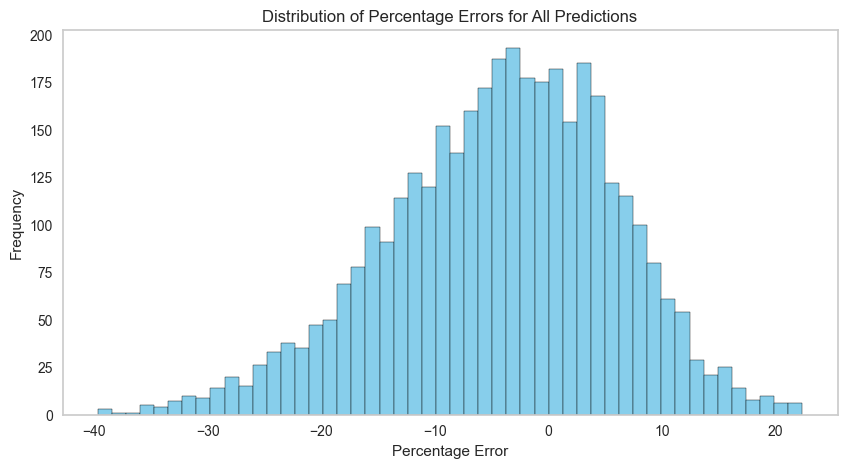

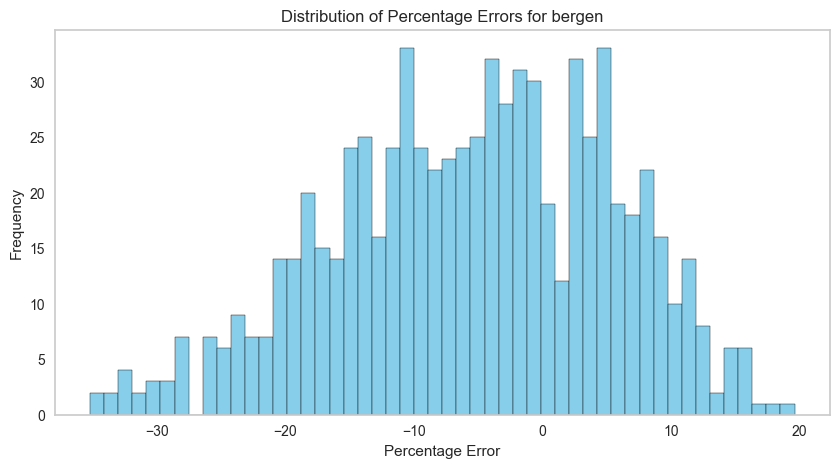

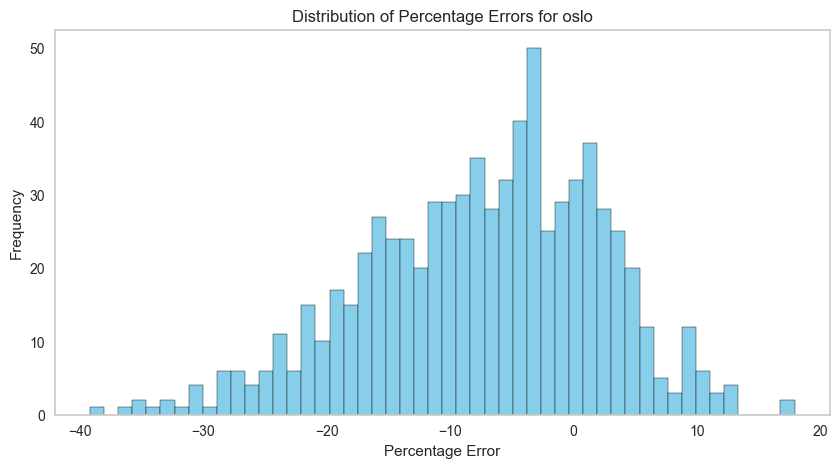

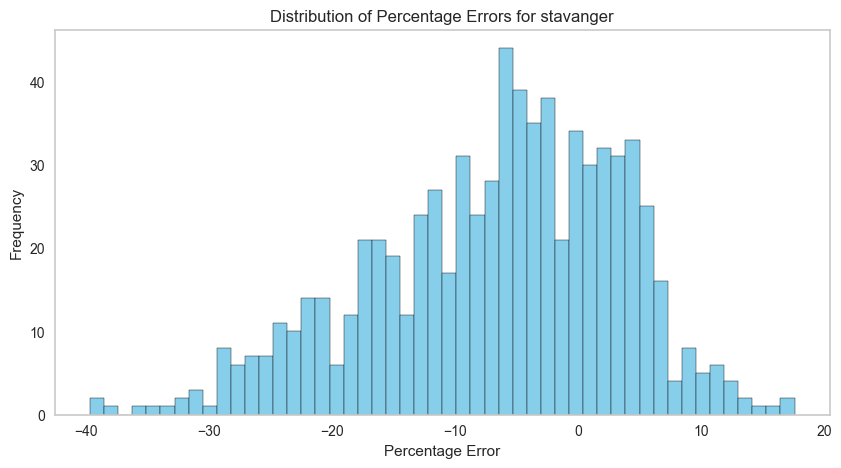

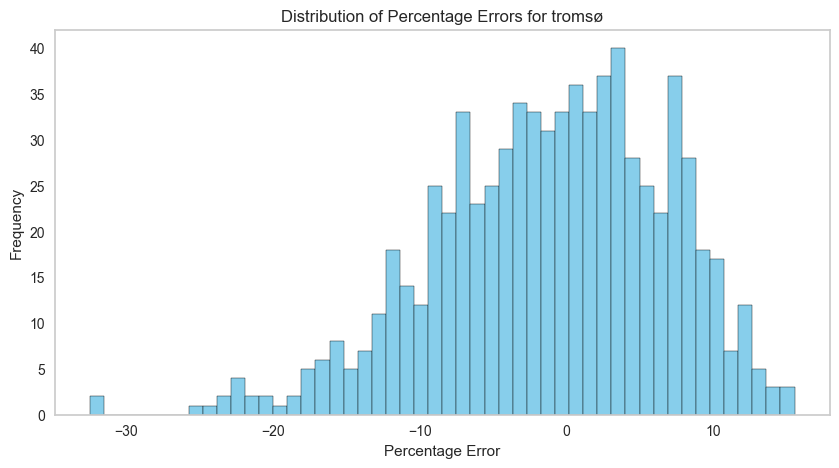

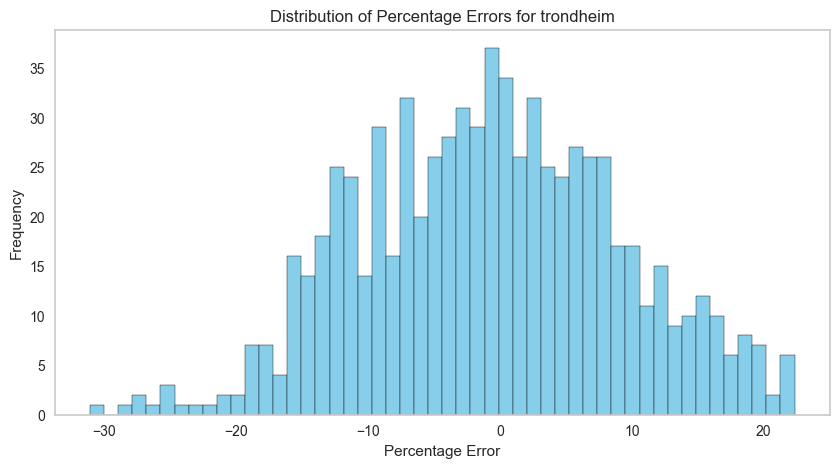

In [96]:
import matplotlib.pyplot as plt

# Function to calculate percentage errors
def calculate_percentage_errors(true_values, predicted_values):
    return ((true_values - predicted_values) / true_values) * 100

# Calculate percentage errors for all predictions combined
all_percentage_errors_individual = []
for location in combined_predictions_entire['original_location'].unique():

    subset_df = combined_predictions_entire[combined_predictions_entire['original_location'] == location]

    subset_df.sort_values(by='time', inplace=True)
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    
    percentage_errors = calculate_percentage_errors(true_values, predicted_values)
    all_percentage_errors_individual.extend(percentage_errors)

# Plot histogram of percentage errors for all predictions combined
plt.figure(figsize=(10, 5))
plt.hist(all_percentage_errors_individual, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Percentage Errors for All Predictions')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Plot histogram of percentage errors for each location
for location in combined_predictions_entire['original_location'].unique():

    subset_df = combined_predictions_entire[combined_predictions_entire['original_location'] == location]

    subset_df.sort_values(by='time', inplace=True)
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    percentage_errors = calculate_percentage_errors(true_values, predicted_values)
    
    plt.figure(figsize=(10, 5))
    plt.hist(percentage_errors, bins=50, edgecolor='black', color='skyblue')
    plt.title(f'Distribution of Percentage Errors for {location}')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()
